In [ ]:
import os
import glob
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Configuration
POSITIVE_DIR = "/content/DDS1/PP/IMAGE" # Path on colab
NEGATIVE_DIR = "/content/DDS1/NP/IMAGE" # Path on colab

In [ ]:
# Global Params
IMG_WIDTH = 40
IMG_HEIGHT = 40
IMG_CHANNELS = 3  # RGB
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

TEST_SPLIT_SIZE = 0.2
CNN_VALIDATION_SPLIT = 0.2
CNN_EPOCHS = 20
CNN_BATCH_SIZE = 32

In [ ]:
# Data Loading Function

def load_and_preprocess_images(positive_dir, negative_dir):
    """
    Loads all .bmp images from the positive and negative directories,
    resizes them, normalizes them, and returns them as numpy arrays.
    """
    images = []
    labels = []

    print(f"Loading images from: {positive_dir} (Label 1)")
    pos_files = glob.glob(os.path.join(positive_dir, "*.bmp"))
    print(f"Found {len(pos_files)} positive images.")

    for img_path in pos_files:
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise Exception("Image could not be read.")
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

            images.append(img_resized)
            labels.append(1)  # 1 for 'positive'
        except Exception as e:
            print(f"Warning: Could not load image {img_path}. Error: {e}")

    print(f"Loading images from: {negative_dir} (Label 0)")
    neg_files = glob.glob(os.path.join(negative_dir, "*.bmp"))
    print(f"Found {len(neg_files)} negative images.")

    for img_path in neg_files:
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise Exception("Image could not be read.")
            img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            if len(img_resized.shape) == 2 or img_resized.shape[2] == 1:
                img_resized = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

            images.append(img_resized)
            labels.append(0)
        except Exception as e:
            print(f"Warning: Could not load image {img_path}. Error: {e}")

    print("Converting to NumPy arrays and normalizing...")
    images_np = np.array(images, dtype="float32") / 255.0
    labels_np = np.array(labels, dtype="int32")

    return images_np, labels_np

In [ ]:
# CNN Model Building Function

def build_cnn_model(input_shape):
    # Define the input layer
    inputs = keras.Input(shape=input_shape, name="input_image")

    # Stack the layers, calling one on top of the other
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    # Name the feature layer
    feature_output = layers.Dense(128, activation='relu', name='feature_layer')(x)

    # Add the classifier head
    x = layers.Dropout(0.5)(feature_output)
    classifier_output = layers.Dense(1, activation='sigmoid', name='classifier_head')(x)

    # Create the model by defining its inputs and outputs
    model = keras.Model(inputs=inputs, outputs=classifier_output)

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Plotting Function
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

In [ ]:
def main():
    print("--- Starting CNN Training and Feature Extraction ---")

    # Load and Split Data
    print("\n[Step 1/8] Loading and Preprocessing Data...")
    try:
        all_images, all_labels = load_and_preprocess_images(POSITIVE_DIR, NEGATIVE_DIR)
    except Exception as e:
        print(f"\n!!! ERROR: Failed to load images. !!!")
        print(f"Please check your directory paths. Error: {e}")
        return

    if all_images.shape[0] == 0:
        print("\n!!! ERROR: No images were loaded. !!!")
        return

    print(f"\nSuccessfully loaded {all_images.shape[0]} images.")

    # Split data into a training set and a final holdout test set
    X_train_imgs, X_test_imgs, y_train_labels, y_test_labels = train_test_split(
        all_images,
        all_labels,
        test_size=TEST_SPLIT_SIZE,
        random_state=42,
        stratify=all_labels
    )
    print(f"Data split into {len(X_train_imgs)} training samples and {len(X_test_imgs)} test samples.")


    print("\n[Step 2/8] Setting manual class weights for imbalanced data")
    # Penalize mistakes on Positive 4x more
    class_weights_dict = {
        0: 1.0,
        1: 4.0
    }


    # TRAIN AND EVALUATE THE FULL CNN

    print("\n[Step 3/8] Building Full CNN Classifier...")
    full_cnn_model = build_cnn_model(IMG_SHAPE)

    full_cnn_model.summary()

    print("\n[Step 4/8] Training CNN (This is the longest step)...")
    history = full_cnn_model.fit(
        X_train_imgs, y_train_labels,
        epochs=CNN_EPOCHS,
        batch_size=CNN_BATCH_SIZE,
        validation_split=CNN_VALIDATION_SPLIT,
        class_weight=class_weights_dict,
        verbose=1
    )

    print("\n[Step 5/8] Evaluating CNN on the holdout test set...")
    y_pred_proba_cnn = full_cnn_model.predict(X_test_imgs).ravel()
    y_pred_class_cnn = (y_pred_proba_cnn > 0.5).astype(int)


    # EXTRACT FEATURES

    print("\n[Step 6/8] Creating feature extractor model...")
    feature_extractor_model = keras.Model(
        inputs=full_cnn_model.input,
        outputs=full_cnn_model.get_layer('feature_layer').output
    )

    print("\n[Step 7/8] Extracting features (running feature extraction)...")
    X_train_features = feature_extractor_model.predict(X_train_imgs)
    X_test_features = feature_extractor_model.predict(X_test_imgs)

    print(f"Shape of extracted training features: {X_train_features.shape}")
    print(f"Shape of extracted test features: {X_test_features.shape}")

    # SAVE AND EXPORT THE FEATURES

    print("\n[Step 8/8] Saving extracted features to file...")
    OUTPUT_FILENAME = "cnn_extracted_features.npz"
    np.savez_compressed(
        OUTPUT_FILENAME,
        X_train_features=X_train_features,
        y_train_labels=y_train_labels,
        X_test_features=X_test_features,
        y_test_labels=y_test_labels
    )


    # FINAL CNN RESULTS

    print("\n\n--- === CNN PERFORMANCE REPORT  === ---")

    print(classification_report(y_test_labels, y_pred_class_cnn, target_names=['Negative (NP)', 'Positive (PP)']))
    print(f"CNN AUC-ROC Score: {roc_auc_score(y_test_labels, y_pred_proba_cnn):.4f}")
    plot_confusion_matrix(y_test_labels, y_pred_class_cnn, "CNN Confusion Matrix")
    print("--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---")

--- Starting CNN Training and Feature Extraction ---

[Step 1/8] Loading and Preprocessing Data...
Loading images from: /content/DDS1/PP/IMAGE (Label 1)
Found 2636 positive images.
Loading images from: /content/DDS1/NP/IMAGE (Label 0)
Found 28848 negative images.
Converting to NumPy arrays and normalizing...

Successfully loaded 31484 images.
Data split into 25187 training samples and 6297 test samples.

[Step 2/8] Setting manual class weights for imbalanced data

[Step 3/8] Building Full CNN Classifier...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 40, 40, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 10, 10, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier_head (Dense)         │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 503,105 (1.92 MB)

 Trainable params: 503,105 (1.92 MB)

 Non-trainable params: 0 (0.00 B)


[Step 4/8] Training CNN (This is the longest step)...
Epoch 1/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 52s 81ms/step - accuracy: 0.9109 - loss: 0.7195 - val_accuracy: 0.9117 - val_loss: 0.3676
Epoch 2/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 50s 80ms/step - accuracy: 0.9187 - loss: 0.7020 - val_accuracy: 0.9117 - val_loss: 0.4877
Epoch 3/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.9164 - loss: 0.6925 - val_accuracy: 0.9117 - val_loss: 0.3301
Epoch 4/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 52s 82ms/step - accuracy: 0.9079 - loss: 0.7009 - val_accuracy: 0.8960 - val_loss: 0.2897
Epoch 5/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 50s 79ms/step - accuracy: 0.8967 - loss: 0.6395 - val_accuracy: 0.8956 - val_loss: 0.3230
Epoch 6/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.9237 - loss: 0.4052 - val_accuracy: 0.9726 - val_loss: 0.0789
Epoch 7/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 83s 80ms/step - accuracy: 0.9658 - loss: 0.2081 - val_accuracy: 0.9849 - val_loss: 0.0585
Epoch 8/20
630/630 ━━━━━━━━━━━━━━━━

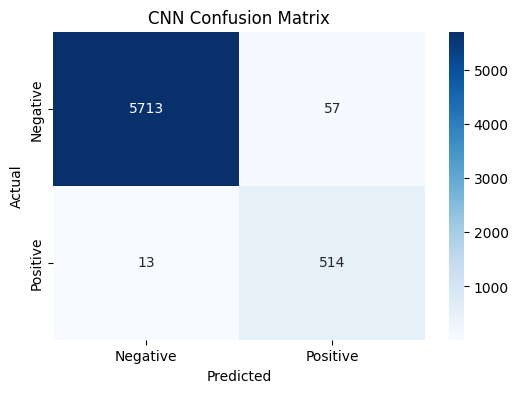

--- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


In [ ]:
# Run the main workflow
if __name__ == "__main__":
    main()

In [ ]:
# Load the file
data = np.load("cnn_extracted_features.npz")

print("Arrays saved in the file:")
print(data.files)

# Print the shape
X_train = data['X_train_features']
print("\nShape of the training features:")
print(X_train.shape)
print(X_train[:5])

# The first 5 training labels
y_train = data['y_train_labels']
print("\nFirst 5 training labels:")
print(y_train[:5])

Arrays saved in the file:
['X_train_features', 'y_train_labels', 'X_test_features', 'y_test_labels']

Shape of the training features:
(25187, 128)
[[2.5491507  0.         0.         0.         0.         0.
  1.2704284  0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.6994079  0.         0.         0.         0.
  1.2463518  0.         0.         0.         2.1699214  0.
  1.171448   1.152082   0.         0.         0.         1.7193786
  0.         0.         0.         2.4169314  0.         0.
  0.         0.         0.         0.         1.7539264  0.
  1.05637    0.         0.         0.         0.         0.
  0.         0.         1.5091593  0.         0.         1.7092705
  0.         2.4806206  0.         1.7305171  1.2969792  0.
  0.         0.         0.         1.1216779  0.         0.
  0.         0.         2.4830282  0.         0.         2.217838
  0.         0.         0.         1.4526032  1.20974